In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile
from scipy.io import savemat
from scipy.signal import correlate
import IPython
import heapq

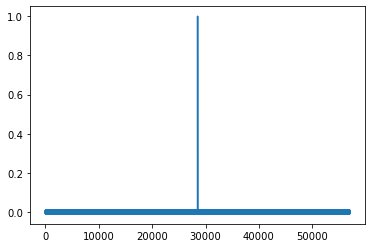

(57040,)


In [3]:
#uni_white_noise = np.random.uniform(-1,1,57040)
uni_white_noise = np.random.uniform(-0.01,0.01,57040)
uni_white_noise[28520] = 1

plt.plot(uni_white_noise)
plt.show()
print(uni_white_noise.shape)

In [4]:
def get_rir(size='medium', absorption='medium', order = 0):
    if absorption=='high':
        absor = 0.9
    elif absorption=='medium':
        absor = 0.3
    elif absorption=='low':
        absor = 0.1
    else:
        raise ValueError("The absorption parameter can only take values ['low', 'medium', 'high']")
    
    if size=='large':
        size_coef = 5.
    elif size=='medium':
        size_coef = 2.5
    elif size=='small':
        size_coef = 1.
    else:
        raise ValueError("The size parameter can only take values ['small', 'medium', 'large']")
        
        
    pol = size_coef * np.array([[0,0], [0,6], [5,6], [5,0]]).T
    room = pra.Room.from_corners(pol, fs=16000, max_order=order, absorption=absor)

    # Create the 3D room by extruding the 2D by a specific height
    room.extrude(size_coef * 2.5, absorption=absor)

    # Adding the source
    room.add_source(size_coef * np.array([1.8, 0.4, 1.6]), signal=uni_white_noise)

    # Adding the microphones
    R = size_coef * np.array([[2.5, 2.9, 0.5], 
                              [2.0, 2.0, 0.8], 
                              [1.5, 1.5, 1.0], 
                              [1.0, 0.5, 0.6], 
                              [2.5, 0.5, 1.0],
                              [2.9, 1.0, 1.2],
                              [0.5, 1.5, 1.0],
                              [0.8, 3.5, 1.5],
                              [2.9, 2.5, 1.0],
                              [2.0, 3.9, 1.6]])
    R = np.transpose(R)
    room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

    # Compute the RIR
    room.compute_rir()

    # Plot and apply the RIR on the audio file
    #room.plot_rir()
    #plt.show()
    room.simulate()
    room.mic_array.to_wav('aaa.wav', norm=True, bitdepth=np.int16)
    
    # Display the audio file
    fs_result, result = wavfile.read('aaa.wav')
    #IPython.display.display(IPython.display.Audio(result, rate=fs_result))
    
    return room.rir

(10, 1)


/home/manav/anaconda3/lib/python3.8/site-packages/pyroomacoustics/room.py:1163: UserWarning: Using absorption parameter is deprecated. In the future, use materials instead.
  warnings.warn(
<ipython-input-5-58d19dc2e74e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rir_small = np.array(rir_small)


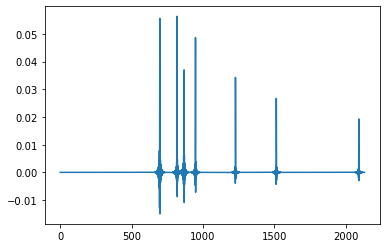

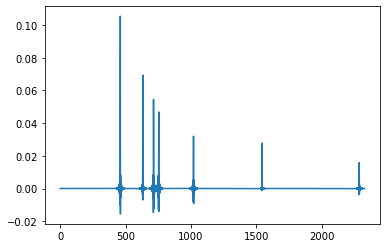

In [5]:
rir_small = get_rir(size='large', absorption='low', order = 1)

rir_small = np.array(rir_small)
print(rir_small.shape)

plt.plot(rir_small[0][0])
plt.show()

plt.plot(rir_small[1][0])
plt.show()

# ROOM IMPULSE RESPONSE TIMESTAMPS

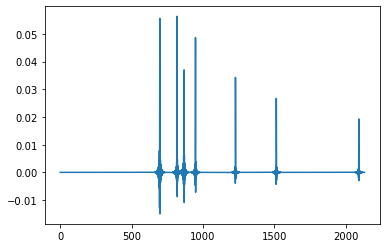

[697, 698, 819, 867, 868, 948, 1228, 1514, 2092]
2133
[0, 3]
[0.043625  0.0511875 0.05425   0.05925   0.07675   0.094625  0.13075  ]


In [6]:
#Microphone 1
plt.plot(rir_small[0][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[0][0])):
    if(rir_small[0][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[0][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 4):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

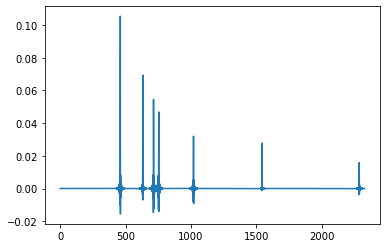

[459, 460, 632, 714, 715, 753, 754, 1019, 1020, 1545, 2287]
2329
[0, 3, 5, 7]
[0.02875   0.0395    0.0446875 0.047125  0.06375   0.0965625 0.1429375]


In [7]:
#Microphone 2
plt.plot(rir_small[1][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[1][0])):
    if(rir_small[1][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[1][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 4):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

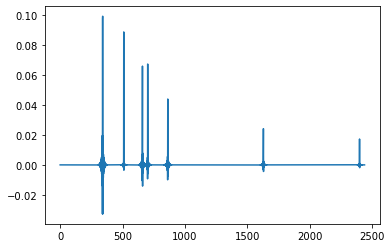

[338, 340, 341, 343, 510, 659, 660, 702, 863, 864, 1630, 2401]
2442
[0, 1, 2, 5, 8]
[0.0214375 0.031875  0.04125   0.043875  0.054     0.101875  0.1500625]


In [8]:
#Microphone 3
plt.plot(rir_small[2][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[2][0])):
    if(rir_small[2][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[2][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 4):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

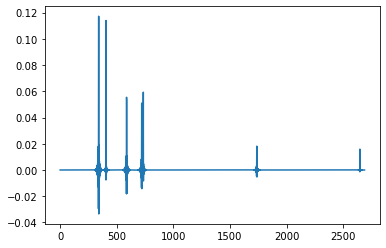

[337, 339, 340, 342, 405, 586, 587, 719, 720, 734, 1736, 2646]
2688
[0, 1, 2, 5, 7]
[0.021375  0.0253125 0.0366875 0.045     0.045875  0.1085    0.165375 ]


In [9]:
#Microphone 4

plt.plot(rir_small[3][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[3][0])):
    if(rir_small[3][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[3][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 4):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

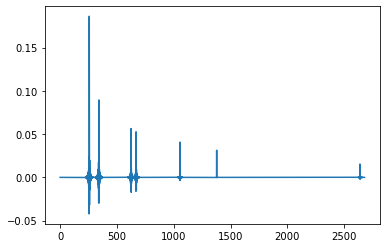

[254, 256, 257, 259, 338, 340, 341, 343, 623, 624, 668, 669, 1053, 1377, 2638]
2679
[0, 1, 2, 4, 5, 6, 8, 10]
[0.0161875 0.0214375 0.039     0.0418125 0.0658125 0.0860625 0.164875 ]


In [10]:
#Microphone 5

plt.plot(rir_small[4][0])
plt.show()

peaks = []
thresh = 0.015

for i in range(len(rir_small[4][0])):
    if(rir_small[4][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[4][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 4):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

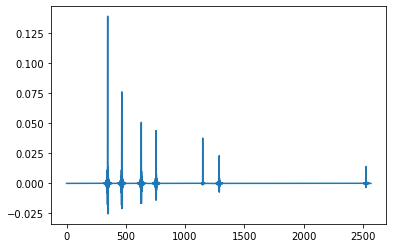

[346, 347, 465, 466, 630, 631, 755, 756, 1149, 1287, 1288, 2527]
2569
[0, 2, 4, 6, 9]
[0.0216875 0.029125  0.0394375 0.04725   0.0718125 0.0805    0.1579375]


In [11]:
#Microphone 6

plt.plot(rir_small[5][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[5][0])):
    if(rir_small[5][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[5][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 2):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

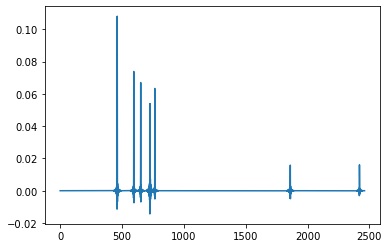

[461, 462, 595, 651, 726, 727, 765, 1860, 2419]
2461
[0, 4]
[0.028875  0.0371875 0.0406875 0.0454375 0.0478125 0.11625   0.1511875]


In [12]:
#Microphone 7

plt.plot(rir_small[6][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[6][0])):
    if(rir_small[6][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[6][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 2):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

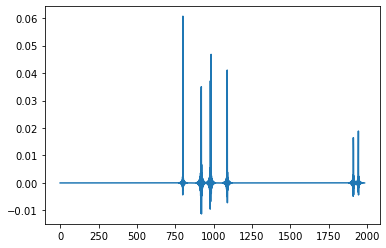

[800, 919, 920, 979, 980, 984, 1089, 1911, 1944]
1985
[1, 3]
[0.05      0.0575    0.06125   0.0615    0.0680625 0.1194375 0.1215   ]


In [13]:
#Microphone 8

plt.plot(rir_small[7][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[7][0])):
    if(rir_small[7][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[7][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 2):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

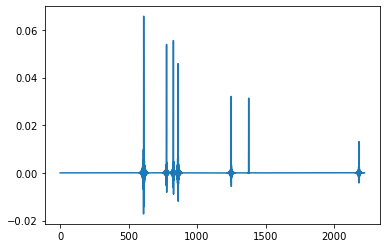

[610, 611, 776, 777, 826, 827, 860, 861, 1249, 1377, 2182, 2183]
2224
[0, 2, 4, 6, 10]
[0.0381875 0.0485625 0.0516875 0.0538125 0.0780625 0.0860625 0.1364375]


In [14]:
#Microphone 9

plt.plot(rir_small[8][0])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(rir_small[8][0])):
    if(rir_small[8][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[8][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 2):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

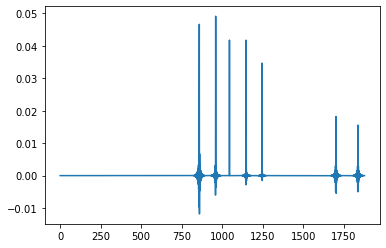

[857, 858, 959, 1044, 1147, 1245, 1701, 1836, 1837]
1878
[0, 7]
[0.053625  0.0599375 0.06525   0.0716875 0.0778125 0.1063125 0.1148125]


In [15]:
#Microphone 10

plt.plot(rir_small[9][0])
plt.show()

peaks = []
thresh = 0.014

for i in range(len(rir_small[9][0])):
    if(rir_small[9][0][i] > thresh):
        peaks.append(i)
print(peaks)
print(len(rir_small[9][0]))

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 2):
        idx.append(i)
print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

In [16]:
rir_done = []

for i in range(10):
    for row in rir_small[i]:
        rir_done.append(row)
        print(len(row))

2133
2329
2442
2688
2679
2569
2461
1985
2224
1878


In [17]:
out = []

for i in range(10):
    o = np.convolve(uni_white_noise, rir_done[i])
    out.append(o)

# OUTPUT SIGNAL TIMESTAMPS

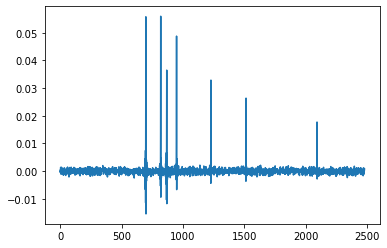

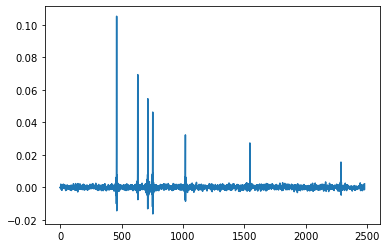

[1.826125, 1.8336875, 1.8366875, 1.84175, 1.85925, 1.877125, 1.91325]


In [25]:
#Microphone 1
plt.plot(out[0][57040//2:31000])
plt.show()

plt.plot(out[1][57040//2:31000])
plt.show()

peaks = []
thresh = 0.015

for i in range(len(out[0])):
    if(out[0][i] > thresh):
        peaks.append(i)
#print(peaks)
        
idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 2):
        idx.append(i)
        
for i in range(len(idx)):
    peaks.pop(idx[i])
        
for i in range(len(peaks)):
    #peaks[i] = peaks[i] - (57040//2)#Centering at zero
    peaks[i] = float(peaks[i])/16000 #Dividing by Sampling Frequency to get answers in seconds
    
print(peaks)

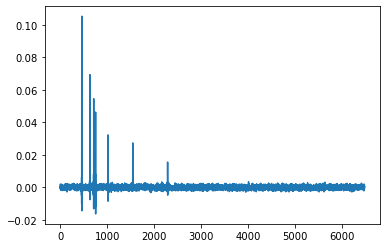

[1.81125   1.822     1.8271875 1.829625  1.84625   1.8790625 1.9254375]


In [26]:
#Microphone 2
plt.plot(out[1][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[1])):
    if(out[1][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

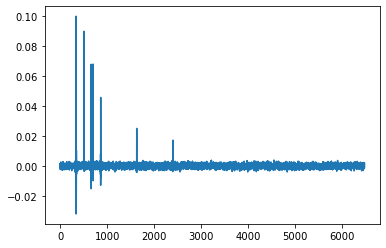

[1.8040625 1.814375  1.82375   1.8264375 1.8365    1.884375  1.9325625]


In [27]:
#Microphone 3
plt.plot(out[2][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[2])):
    if(out[2][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

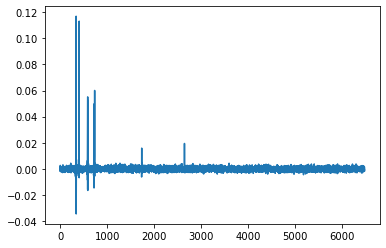

[1.803875  1.8078125 1.8191875 1.8275    1.828375  1.891     1.947875 ]


In [29]:
#Microphone 4
plt.plot(out[3][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[3])):
    if(out[3][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

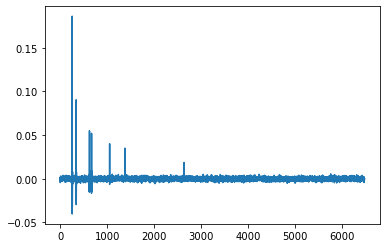

[1.7986875 1.8039375 1.821625  1.8243125 1.8483125 1.8685625 1.947375 ]


In [30]:
#Microphone 5
plt.plot(out[4][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[4])):
    if(out[4][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

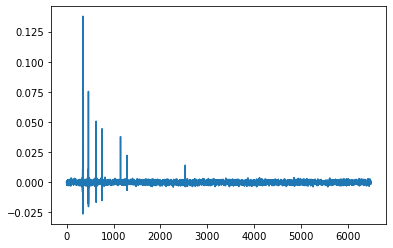

[1.8043125 1.81175   1.8219375 1.82975   1.8543125 1.863     1.9404375]


In [31]:
#Microphone 6
plt.plot(out[5][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[5])):
    if(out[5][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

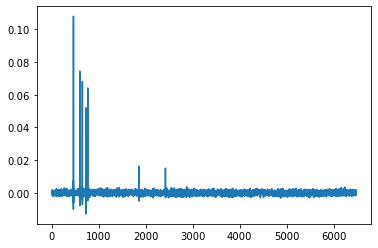

[1.811375  1.8196875 1.8231875 1.8279375 1.8303125 1.89875   1.9336875]


In [32]:
#Microphone 7
plt.plot(out[6][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[6])):
    if(out[6][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

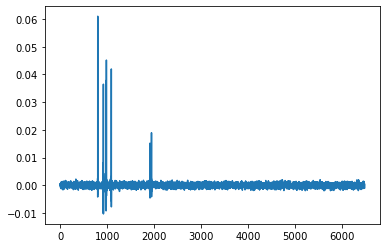

[1.8325    1.84      1.84375   1.844     1.8505625 1.902     1.904    ]


In [33]:
#Microphone 8
plt.plot(out[7][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[7])):
    if(out[7][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

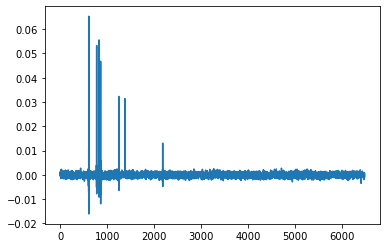

[1.8206875 1.8310625 1.8341875 1.8363125 1.8605625 1.8685625 1.9189375]


In [34]:
#Microphone 9
plt.plot(out[8][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[8])):
    if(out[8][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

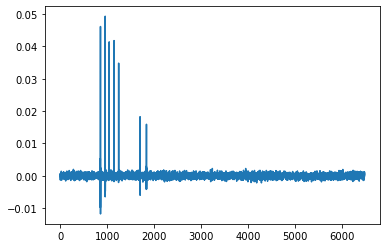

[1.836125  1.8424375 1.84775   1.8541875 1.8603125 1.8888125 1.8973125]


In [35]:
#Microphone 10
plt.plot(out[9][57040//2:35000])
plt.show()

peaks = []
thresh = 0.010

for i in range(len(out[9])):
    if(out[9][i] > thresh):
        peaks.append(i)
#print(peaks)

peaks = np.array(peaks)

idx = []
for i in range(len(peaks) - 1):
    if(peaks[i+1] - peaks[i] < 3):
        idx.append(i)
#print(idx)

peaks_del = np.delete(peaks, idx)
    
print(np.array(peaks_del)/16000)

59172
59368


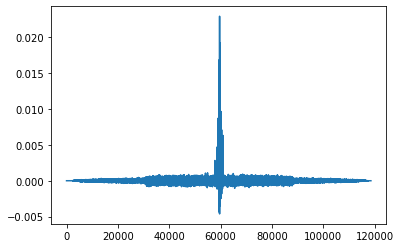

In [20]:
print(len(out[0]))
print(len(out[1]))
ans = correlate(out[0],out[1],"full")
ans2 = correlate(out[1], out[0], "full")

plt.plot(ans)
plt.show()

In [21]:
print(heapq.nlargest(1,range(len(ans)),ans.take))
print(heapq.nlargest(1,range(len(ans2)), ans2.take))

[59605]
[58933]


In [22]:
tij = np.zeros((10,10))
cnt = 0

for i in range(10):
    for j in range(10):
        print(cnt)
        cnt = cnt + 1
        if(i == j):
            continue
        else:
            ans = np.correlate(out[i],out[j],"full")
            val = heapq.nlargest(1,range(len(ans)),ans.take)
            tij[i][j] = val[0]/16000
            
print(abs(tij))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[[0.        3.7253125 3.7398125 3.75525   3.759875  3.747375  3.725125
  3.6750625 3.7093125 3.67225  ]
 [3.6833125 0.        3.7249375 3.740375  3.7450625 3.7325    3.718625
  3.6676875 3.6809375 3.657375 ]
 [3.675875  3.703     0.        3.7329375 3.7375625 3.7250625 3.711125
  3.65275   3.687     3.6499375]
 [3.6758125 3.7029375 3.7174375 0.        3.7375    3.725     3.7151875
  3.66425   3.6869375 3.649875 ]
 [3.670625  3.6976875 3.71225   3.7276875 0.        3.7198125 3.705875
  3.6549375 3.68175   3.6383125]
 [3.67625   3.703375  3.717875  3.7333125 3.7379375 0.        3.7115625
  3.6605625 3.687375  3.6503125]
 [3.69175   3.7105    3.7250625 3.736375  3.745125  3.7325625 0.
  3.66775   3.69456